In [ ]:
!pip install scipy --upgrade

### imports

In [1]:
import scipy.io
import numpy as np
from tqdm.auto import tqdm
from functools import partial
from google.colab import drive
import matplotlib.pyplot as plt
from itertools import combinations

# pytorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tqdm = partial(tqdm, position=0, leave=False)
print(device)

cuda:0


In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/WorkSpace

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/WorkSpace


In [3]:
from modules import data_f, network_f, network_architectures

### load the data from mat file

In [4]:
mat = scipy.io.loadmat('datasets/DREAMER.mat', simplify_cells=True)
data = mat['DREAMER']['Data']
score_types = ['ScoreValence', 'ScoreArousal', 'ScoreDominance']

### interpolate the signals to be of equal length

In [5]:
#person1 = data[0]

inputs = []
labels = []
for person in tqdm(data):
  scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
  # scores -= 1  # [1,5] -> [0,4]
  scores = np.where(scores>=2.5, 1, 0).astype(float)  # [1,5] -> 0/1 

  person_signals = []
  for vid in tqdm(range(18)):
    signal_vals = []
    for signal_type in ['EEG', 'ECG']:
      for signal_mode in ['baseline', 'stimuli']:
        signal = person[signal_type][signal_mode][vid]
        for channel in np.swapaxes(signal,0,1):
          ch_interp = np.interp(np.linspace(0,len(channel)-1,32768), range(len(channel)), channel)
          signal_vals.append(ch_interp)
    person_signals.append(signal_vals)

  inputs.append(person_signals)
  labels.append(scores)  


inputs = np.array(inputs)
labels = np.array(labels)
print(inputs.shape)
print(labels.shape, np.unique(labels))
data = inputs, labels



# normalize the signals to be in range(-1,1)
for inp in inputs: data_f.normalize(inp)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

(23, 18, 32, 32768)
(23, 18, 3) [0. 1.]


## Using full dataset

In [6]:
inputs, labels = data
inputs = inputs.reshape(-1, *inputs.shape[2:])
labels = labels.reshape(-1, *labels.shape[2:])

### create dataloader

In [36]:
dataloaders = data_f.create_trainValLoaders(inputs, labels, test_size=.25, batch_size=32)

### define the network

view network summary

In [37]:
model = network_architectures.Conv_Classifier(num_classes=3, inp_channels=32)
model = model.to(device)

summary(model, (32,32768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 8190]          24,640
              ReLU-2             [-1, 64, 8190]               0
         MaxPool1d-3             [-1, 64, 2048]               0
            Conv1d-4             [-1, 192, 512]          49,344
              ReLU-5             [-1, 192, 512]               0
         MaxPool1d-6             [-1, 192, 128]               0
            Conv1d-7             [-1, 384, 128]         221,568
              ReLU-8             [-1, 384, 128]               0
            Conv1d-9             [-1, 256, 128]         295,168
             ReLU-10             [-1, 256, 128]               0
           Conv1d-11             [-1, 256, 128]         196,864
             ReLU-12             [-1, 256, 128]               0
        MaxPool1d-13              [-1, 256, 32]               0
AdaptiveAvgPool1d-14               [-1,

set criterion and optimizer

In [38]:
# Define a Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train the network

training network


  0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.108, val loss: 1.809  | avg train loss: 0.055, avg val loss: 3.085


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 40  | train loss: 0.005, val loss: 3.023  | avg train loss: 0.027, avg val loss: 3.424


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 60  | train loss: 0.006, val loss: 2.843  | avg train loss: 0.028, avg val loss: 3.102


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 80  | train loss: 0.050, val loss: 5.005  | avg train loss: 0.017, avg val loss: 4.173


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 100  | train loss: 0.000, val loss: 6.346  | avg train loss: 0.000, avg val loss: 5.501


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 120  | train loss: 0.000, val loss: 8.160  | avg train loss: 0.000, avg val loss: 7.376


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 140  | train loss: 0.000, val loss: 8.560  | avg train loss: 0.000, avg val loss: 8.355


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 160  | train loss: 0.062, val loss: 3.453  | avg train loss: 0.007, avg val loss: 8.251


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 180  | train loss: 0.130, val loss: 3.034  | avg train loss: 0.075, avg val loss: 2.179


train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

train:   0%|          | 0/10 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

epoch: 200  | train loss: 0.000, val loss: 3.980  | avg train loss: 0.030, avg val loss: 2.939
Finished Training


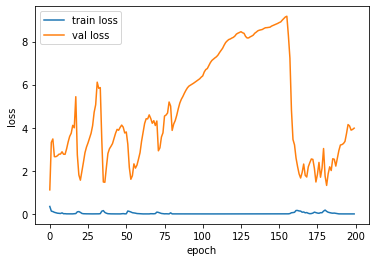

In [46]:
model.apply(network_f.weight_reset)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=200)

In [43]:
# model.load_state_dict(best_params)

### evaluate

In [47]:
print("evaluation results on train data")
lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['train'], predict_fn='threshold')
lbl_true, lbl_pred = [list(lbl) for lbl in lbl_true], [list(lbl) for lbl in lbl_pred]
print(classification_report(lbl_true, lbl_pred, target_names=score_types, zero_division=0))


print("evaluation results on validation data")
lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['val'], predict_fn='threshold')
lbl_true, lbl_pred = [list(lbl) for lbl in lbl_true], [list(lbl) for lbl in lbl_pred]
print(classification_report(lbl_true, lbl_pred, target_names=score_types, zero_division=0))

evaluation results on train data
                precision    recall  f1-score   support

  ScoreValence       1.00      1.00      1.00       184
  ScoreArousal       1.00      1.00      1.00       232
ScoreDominance       1.00      1.00      1.00       246

     micro avg       1.00      1.00      1.00       662
     macro avg       1.00      1.00      1.00       662
  weighted avg       1.00      1.00      1.00       662
   samples avg       0.96      0.96      0.96       662

evaluation results on validation data
                precision    recall  f1-score   support

  ScoreValence       0.66      0.58      0.62        69
  ScoreArousal       0.66      0.79      0.72        68
ScoreDominance       0.71      0.84      0.77        73

     micro avg       0.68      0.74      0.71       210
     macro avg       0.67      0.74      0.70       210
  weighted avg       0.68      0.74      0.70       210
   samples avg       0.65      0.67      0.62       210



## Leave one out cross validation on groups

as mentioned in the dataset: https://ieeexplore.ieee.org/document/7887697

In [6]:
results = dict.fromkeys(score_types)
for score_type in results:
  results[score_type] = {'Accuracy':[], 'F1 Score':[]}

def print_scores(results):
  for metric in ['Accuracy', 'F1 Score']:
    print(metric)
    for score_type in score_types:
      print(f'{score_type} : {np.mean(results[score_type][metric]):.4f}')
    print()

### using conv neural net

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.336, val loss: 1.833  | avg train loss: 0.494, avg val loss: 1.003
epoch: 40  | train loss: 0.009, val loss: 11.839  | avg train loss: 0.115, avg val loss: 5.760
epoch: 60  | train loss: 0.536, val loss: 1.804  | avg train loss: 0.764, avg val loss: 8.699
epoch: 80  | train loss: 0.219, val loss: 5.306  | avg train loss: 0.315, avg val loss: 6.510
epoch: 100  | train loss: 0.004, val loss: 22.040  | avg train loss: 0.155, avg val loss: 9.698
epoch: 120  | train loss: 0.008, val loss: 8.260  | avg train loss: 0.024, avg val loss: 18.818
epoch: 140  | train loss: 0.464, val loss: 14.917  | avg train loss: 0.313, avg val loss: 12.280
epoch: 160  | train loss: 0.001, val loss: 25.780  | avg train loss: 0.195, avg val loss: 18.022
epoch: 180  | train loss: 0.026, val loss: 69.436  | avg train loss: 0.016, avg val loss: 37.460
epoch: 200  | train loss: 0.001, val loss: 7.806  | avg train loss: 0.188, avg val loss: 17.699
Finished Training


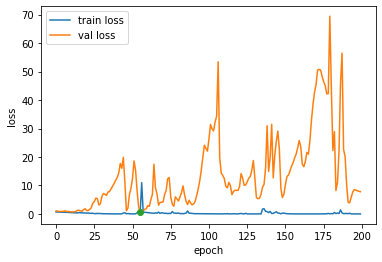

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.299, val loss: 1.195  | avg train loss: 0.503, avg val loss: 0.957
epoch: 40  | train loss: 0.089, val loss: 1.222  | avg train loss: 0.206, avg val loss: 2.255
epoch: 60  | train loss: 0.368, val loss: 0.674  | avg train loss: 0.339, avg val loss: 3.786
epoch: 80  | train loss: 0.373, val loss: 3.785  | avg train loss: 0.328, avg val loss: 1.870
epoch: 100  | train loss: 0.159, val loss: 5.694  | avg train loss: 0.139, avg val loss: 13.579
epoch: 120  | train loss: 0.426, val loss: 1.400  | avg train loss: 0.389, avg val loss: 7.869
epoch: 140  | train loss: 0.271, val loss: 5.792  | avg train loss: 0.139, avg val loss: 4.637
epoch: 160  | train loss: 1.144, val loss: 4.114  | avg train loss: 0.125, avg val loss: 4.803
epoch: 180  | train loss: 0.386, val loss: 3.283  | avg train loss: 0.118, avg val loss: 6.228
epoch: 200  | train loss: 0.037, val loss: 3.991  | avg train loss: 0.108, avg val loss: 3.721
Finished Training


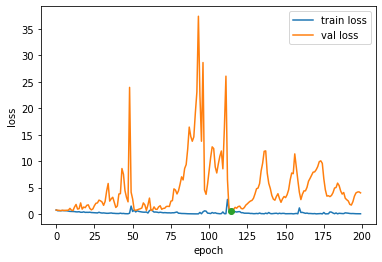

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.197, val loss: 4.388  | avg train loss: 0.425, avg val loss: 1.688
epoch: 40  | train loss: 0.209, val loss: 2.398  | avg train loss: 0.213, avg val loss: 3.252
epoch: 60  | train loss: 0.067, val loss: 1.557  | avg train loss: 0.094, avg val loss: 2.441
epoch: 80  | train loss: 0.321, val loss: 1.056  | avg train loss: 0.262, avg val loss: 3.263
epoch: 100  | train loss: 0.008, val loss: 7.851  | avg train loss: 0.079, avg val loss: 5.285
epoch: 120  | train loss: 4.754, val loss: 0.075  | avg train loss: 0.743, avg val loss: 5.305
epoch: 140  | train loss: 0.202, val loss: 1.654  | avg train loss: 0.322, avg val loss: 1.393
epoch: 160  | train loss: 0.008, val loss: 9.087  | avg train loss: 0.060, avg val loss: 3.957
epoch: 180  | train loss: 0.054, val loss: 9.900  | avg train loss: 0.182, avg val loss: 6.312
epoch: 200  | train loss: 0.026, val loss: 8.245  | avg train loss: 0.050, avg val loss: 6.356
Finished Training


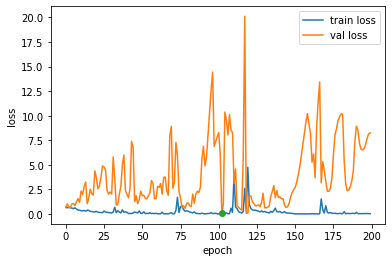

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.334, val loss: 0.501  | avg train loss: 0.518, avg val loss: 0.935
epoch: 40  | train loss: 0.524, val loss: 0.669  | avg train loss: 0.377, avg val loss: 0.969
epoch: 60  | train loss: 0.338, val loss: 0.529  | avg train loss: 0.319, avg val loss: 1.288
epoch: 80  | train loss: 0.003, val loss: 4.643  | avg train loss: 0.072, avg val loss: 1.787
epoch: 100  | train loss: 0.000, val loss: 5.383  | avg train loss: 0.023, avg val loss: 4.450
epoch: 120  | train loss: 0.000, val loss: 9.719  | avg train loss: 0.002, avg val loss: 6.514
epoch: 140  | train loss: 0.963, val loss: 5.614  | avg train loss: 0.050, avg val loss: 11.908
epoch: 160  | train loss: 0.001, val loss: 6.935  | avg train loss: 0.361, avg val loss: 3.020
epoch: 180  | train loss: 0.000, val loss: 7.786  | avg train loss: 0.132, avg val loss: 4.637
epoch: 200  | train loss: 1.608, val loss: 19.738  | avg train loss: 0.111, avg val loss: 8.390
Finished Training


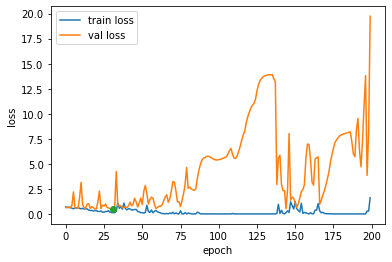

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.468, val loss: 6.126  | avg train loss: 0.566, avg val loss: 1.612
epoch: 40  | train loss: 0.174, val loss: 0.949  | avg train loss: 0.338, avg val loss: 1.902
epoch: 60  | train loss: 0.217, val loss: 0.313  | avg train loss: 0.399, avg val loss: 1.278
epoch: 80  | train loss: 0.057, val loss: 3.231  | avg train loss: 0.292, avg val loss: 1.724
epoch: 100  | train loss: 0.073, val loss: 1.805  | avg train loss: 0.235, avg val loss: 3.545
epoch: 120  | train loss: 0.005, val loss: 2.741  | avg train loss: 0.028, avg val loss: 4.903
epoch: 140  | train loss: 0.000, val loss: 8.021  | avg train loss: 0.001, avg val loss: 5.567
epoch: 160  | train loss: 0.000, val loss: 10.954  | avg train loss: 0.000, avg val loss: 9.057
epoch: 180  | train loss: 0.000, val loss: 11.541  | avg train loss: 0.000, avg val loss: 11.153
epoch: 200  | train loss: 0.000, val loss: 15.133  | avg train loss: 0.000, avg val loss: 12.923
Finished Training


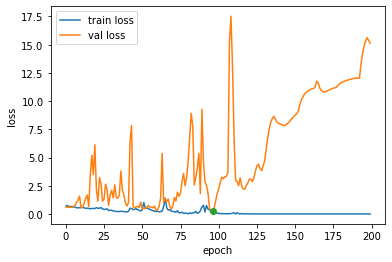

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.341, val loss: 1.341  | avg train loss: 0.541, avg val loss: 0.993
epoch: 40  | train loss: 0.069, val loss: 7.150  | avg train loss: 0.242, avg val loss: 2.340
epoch: 60  | train loss: 0.218, val loss: 0.878  | avg train loss: 0.256, avg val loss: 1.917
epoch: 80  | train loss: 0.946, val loss: 2.787  | avg train loss: 0.192, avg val loss: 2.785
epoch: 100  | train loss: 0.000, val loss: 4.081  | avg train loss: 0.049, avg val loss: 3.791
epoch: 120  | train loss: 0.549, val loss: 0.662  | avg train loss: 0.591, avg val loss: 7.983
epoch: 140  | train loss: 0.400, val loss: 1.189  | avg train loss: 0.420, avg val loss: 1.945
epoch: 160  | train loss: 0.189, val loss: 2.662  | avg train loss: 0.260, avg val loss: 2.414
epoch: 180  | train loss: 0.053, val loss: 4.519  | avg train loss: 0.123, avg val loss: 4.737
epoch: 200  | train loss: 0.077, val loss: 19.837  | avg train loss: 0.100, avg val loss: 15.206
Finished Training


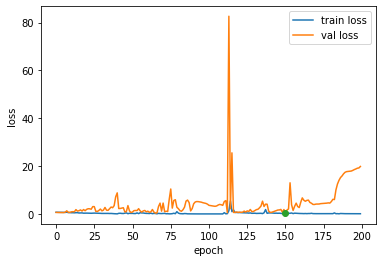

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.250, val loss: 1.099  | avg train loss: 0.529, avg val loss: 0.806
epoch: 40  | train loss: 0.006, val loss: 2.078  | avg train loss: 0.116, avg val loss: 1.372
epoch: 60  | train loss: 0.101, val loss: 3.491  | avg train loss: 0.049, avg val loss: 4.458
epoch: 80  | train loss: 0.167, val loss: 0.578  | avg train loss: 0.243, avg val loss: 1.765
epoch: 100  | train loss: 0.141, val loss: 0.993  | avg train loss: 0.186, avg val loss: 1.191
epoch: 120  | train loss: 0.045, val loss: 8.497  | avg train loss: 0.169, avg val loss: 1.928
epoch: 140  | train loss: 0.044, val loss: 1.100  | avg train loss: 0.309, avg val loss: 2.829
epoch: 160  | train loss: 0.033, val loss: 2.008  | avg train loss: 0.119, avg val loss: 2.783
epoch: 180  | train loss: 0.003, val loss: 0.401  | avg train loss: 0.025, avg val loss: 3.944
epoch: 200  | train loss: 0.130, val loss: 0.834  | avg train loss: 0.073, avg val loss: 1.886
Finished Training


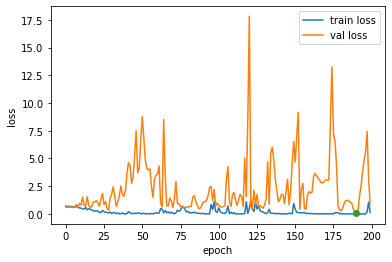

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.312, val loss: 0.397  | avg train loss: 0.472, avg val loss: 0.682
epoch: 40  | train loss: 0.095, val loss: 3.985  | avg train loss: 0.215, avg val loss: 1.436
epoch: 60  | train loss: 0.005, val loss: 8.484  | avg train loss: 0.233, avg val loss: 4.924
epoch: 80  | train loss: 0.032, val loss: 3.519  | avg train loss: 0.348, avg val loss: 5.428
epoch: 100  | train loss: 0.000, val loss: 7.916  | avg train loss: 0.024, avg val loss: 4.974
epoch: 120  | train loss: 1.520, val loss: 5.995  | avg train loss: 0.209, avg val loss: 6.593
epoch: 140  | train loss: 0.079, val loss: 8.203  | avg train loss: 0.281, avg val loss: 4.084
epoch: 160  | train loss: 0.037, val loss: 29.654  | avg train loss: 0.055, avg val loss: 15.753
epoch: 180  | train loss: 0.212, val loss: 1.217  | avg train loss: 0.234, avg val loss: 9.903
epoch: 200  | train loss: 0.017, val loss: 9.806  | avg train loss: 0.096, avg val loss: 3.259
Finished Training


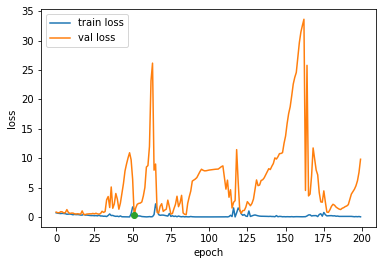

training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.347, val loss: 2.464  | avg train loss: 0.507, avg val loss: 1.200
epoch: 40  | train loss: 0.446, val loss: 3.583  | avg train loss: 0.269, avg val loss: 1.643
epoch: 60  | train loss: 0.123, val loss: 1.248  | avg train loss: 0.127, avg val loss: 3.166
epoch: 80  | train loss: 0.000, val loss: 3.584  | avg train loss: 0.032, avg val loss: 2.196
epoch: 100  | train loss: 0.000, val loss: 4.556  | avg train loss: 0.000, avg val loss: 3.283
epoch: 120  | train loss: 0.000, val loss: 8.445  | avg train loss: 0.000, avg val loss: 8.012
epoch: 140  | train loss: 0.226, val loss: 1.130  | avg train loss: 0.374, avg val loss: 7.899
epoch: 160  | train loss: 0.031, val loss: 2.819  | avg train loss: 0.220, avg val loss: 1.978
epoch: 180  | train loss: 0.000, val loss: 8.818  | avg train loss: 0.044, avg val loss: 5.938
epoch: 200  | train loss: 0.000, val loss: 7.674  | avg train loss: 0.001, avg val loss: 8.628
Finished Training


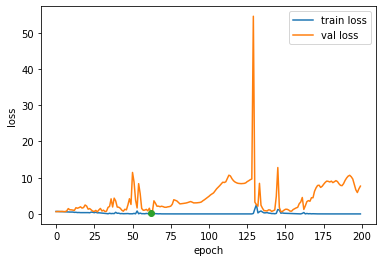

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


training network


  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.237, val loss: 1.346  | avg train loss: 0.474, avg val loss: 1.003
epoch: 40  | train loss: 0.134, val loss: 3.790  | avg train loss: 0.266, avg val loss: 2.190
epoch: 60  | train loss: 0.071, val loss: 4.515  | avg train loss: 0.259, avg val loss: 2.741
epoch: 80  | train loss: 0.198, val loss: 2.080  | avg train loss: 0.241, avg val loss: 2.215
epoch: 100  | train loss: 0.025, val loss: 5.133  | avg train loss: 0.169, avg val loss: 3.095
epoch: 120  | train loss: 0.104, val loss: 1.861  | avg train loss: 0.127, avg val loss: 3.916
epoch: 140  | train loss: 0.230, val loss: 9.349  | avg train loss: 0.154, avg val loss: 4.586
epoch: 160  | train loss: 0.005, val loss: 0.000  | avg train loss: 0.087, avg val loss: 0.542
epoch: 180  | train loss: 0.639, val loss: 0.074  | avg train loss: 0.326, avg val loss: 4.265
epoch: 200  | train loss: 0.006, val loss: 1.237  | avg train loss: 0.126, avg val loss: 1.700
Finished Training


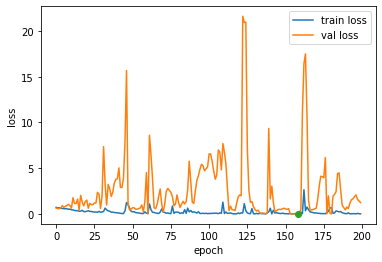

Accuracy
ScoreValence : 0.6500
ScoreArousal : 0.6000
ScoreDominance : 0.6000

F1 Score
ScoreValence : 0.5667
ScoreArousal : 0.4333
ScoreDominance : 0.6667



In [7]:
for person in tqdm(zip(*data), total=len(data[0])):

  inputs, labels = person

  # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
  groups = np.random.choice(range(18), (8,2), replace=False)
  single_groups = [i for i in range(18) if i not in groups]
  groups = [list(group) for group in groups] + single_groups

  for test_group in tqdm(groups):
    train_groups = [group for group in groups if group!=test_group]
    train_groups = np.hstack(train_groups)
    if type(test_group) == int: test_group = [test_group]
    
    train_inputs, train_labels = inputs[train_groups], labels[train_groups]
    test_inputs, test_labels = inputs[test_group], labels[test_group]


    # split data into train and val and then create loaders
    dataloaders = data_f.create_trainValLoaders(train_inputs, train_labels, test_size=1, batch_size=4)
    # just use train data without split
    # dataloaders= {'train' : data_f.createLoader(train_inputs, train_labels, batch_size=2, shuffle=True)}
    dataloaders['test'] = data_f.createLoader(test_inputs, test_labels, batch_size=2)

    model = network_architectures.AlexNet(num_classes=3, inp_channels=32)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=200, verbose=2)
    model.load_state_dict(best_params)

    lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['test'], predict_fn='threshold')
    lbl_true, lbl_pred = list(zip(*lbl_true)), list(zip(*lbl_pred))

    for score_indx, score_type in enumerate(score_types):
      results[score_type]['F1 Score'].append(f1_score(lbl_true[score_indx], lbl_pred[score_indx]))
      results[score_type]['Accuracy'].append(accuracy_score(lbl_true[score_indx], lbl_pred[score_indx]))
  
  print_scores(results)
  break

view final scores

In [8]:
print_scores(results)

Accuracy
ScoreValence : 0.6500
ScoreArousal : 0.6000
ScoreDominance : 0.6000

F1 Score
ScoreValence : 0.5667
ScoreArousal : 0.4333
ScoreDominance : 0.6667



### using SVM

In [ ]:
for run in tqdm(range(10)):
  for person in tqdm(zip(*data), total=len(data[0])):

    inputs, labels = person

    # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
    groups = np.random.choice(range(18), (8,2), replace=False)
    single_groups = [i for i in range(18) if i not in groups]
    groups = [list(group) for group in groups] + single_groups

    for test_group in tqdm(groups):
      train_groups = [group for group in groups if group!=test_group]
      train_groups = np.hstack(train_groups)
      if type(test_group) == int: test_group = [test_group]
      
      train_inputs, train_labels = inputs[train_groups], labels[train_groups]
      test_inputs, test_labels = inputs[test_group], labels[test_group]

      # flatten train and test inputs
      train_inputs = train_inputs.reshape(train_inputs.shape[0],-1)
      test_inputs = test_inputs.reshape(test_inputs.shape[0],-1)

      # train an SVM for each score type
      for score_indx, score_type in enumerate(score_types):
        clf = svm.SVC()
        # clf = svm.LinearSVC()
        n_classes = np.unique(train_labels[:,score_indx])
        if len(n_classes) == 2:
          clf.fit(train_inputs, train_labels[:,score_indx])
          lbl_pred = clf.predict(test_inputs)
        elif len(n_classes) == 1:
          pred_class = n_classes[0]
          lbl_pred = np.full_like(test_labels[:,score_indx], pred_class)

        results[score_type]['F1 Score'].append(f1_score(test_labels[:,score_indx], lbl_pred, zero_division=0))
        results[score_type]['Accuracy'].append(accuracy_score(test_labels[:,score_indx], lbl_pred))  

  print_scores(results)

In [ ]:
print_scores(results)

Accuracy
ScoreValence : 0.5812
ScoreArousal : 0.6838
ScoreDominance : 0.7577

F1 Score
ScoreValence : 0.5145
ScoreArousal : 0.7259
ScoreDominance : 0.7689



### using KNN

In [ ]:
import sys
from sklearn.cluster import MiniBatchKMeans


for _ in tqdm(range(10)):
  for person in tqdm(zip(*data), total=len(data[0])):

    inputs, labels = person

    # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
    groups = np.random.choice(range(18), (8,2), replace=False)
    single_groups = [i for i in range(18) if i not in groups]
    groups = [list(group) for group in groups] + single_groups

    for test_group in tqdm(groups):
      train_groups = [group for group in groups if group!=test_group]
      train_groups = np.hstack(train_groups)
      if type(test_group) == int: test_group = [test_group]
      
      train_inputs, train_labels = inputs[train_groups], labels[train_groups]
      test_inputs, test_labels = inputs[test_group], labels[test_group]

      # flatten train and test inputs
      train_inputs = train_inputs.reshape(train_inputs.shape[0],-1)
      test_inputs = test_inputs.reshape(test_inputs.shape[0],-1)

      neigh = KNeighborsClassifier(n_neighbors=1)
      neigh.fit(train_inputs, train_labels)
      lbl_pred = neigh.predict(test_inputs)

      # train an SVM for each score type
      for score_indx, score_type in enumerate(score_types):
        results[score_type]['F1 Score'].append(f1_score(test_labels[:, score_indx], lbl_pred[:, score_indx], zero_division=0))
        results[score_type]['Accuracy'].append(accuracy_score(test_labels[:, score_indx], lbl_pred[:, score_indx]))

  print_scores(results)

In [52]:
print_scores(results)

Accuracy
ScoreValence : 0.5573
ScoreArousal : 0.6588
ScoreDominance : 0.7179

F1 Score
ScoreValence : 0.4700
ScoreArousal : 0.6691
ScoreDominance : 0.7268

